In [1]:
import numpy as np, numpy.random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import rl_utils

In [17]:
def set_seed(random_seed):
#     random.seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.backends.cudnn.benckmark = False
    torch.backends.cudnn.deterministic = True
    torch.set_default_dtype(torch.float32)
    
# set_seed(2024)

In [3]:
# Check CUDA
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: Quadro M1000M


In [5]:
csvFile = pd.read_csv('../Dataset/CarbonScribingPolyimide_SE_Data.csv')
df = csvFile
df_parameter = df.iloc[:, 1:7]
df_SE = df.iloc[:, 0]

In [6]:
max_values_parameter = df_parameter.max()
max_values_parameter

Pulse Duration (nanoSeconds)                                   200.00
Pulse Frequency (KHz)                                         1000.00
Power (% of 20W Max Output)                                     87.73
Speed (mm/s)                                                  1415.89
Distance between Passes of Laser (microns)                    1322.06
Ink Type (0=No Ink, 1=TopInk, 2=BottomInk,3=Both Sides Ink       3.00
dtype: float64

In [7]:
max_values_parameter[2] = 100.0
max_values_parameter[3] = 1500.0
max_values_parameter[4] = 1500.0
max_values_parameter

Pulse Duration (nanoSeconds)                                   200.0
Pulse Frequency (KHz)                                         1000.0
Power (% of 20W Max Output)                                    100.0
Speed (mm/s)                                                  1500.0
Distance between Passes of Laser (microns)                    1500.0
Ink Type (0=No Ink, 1=TopInk, 2=BottomInk,3=Both Sides Ink       3.0
dtype: float64

In [13]:
# Normalization Parameters
df_parameter_norm = df_parameter / max_values_parameter
df_parameter_norm.head()

,Pulse Duration (nanoSeconds),Pulse Frequency (KHz),Power (% of 20W Max Output),Speed (mm/s),Distance between Passes of Laser (microns),"Ink Type (0=No Ink, 1=TopInk, 2=BottomInk,3=Both Sides Ink"
0,1.0,0.4,0.3,0.053333,0.666667,0.666667
1,1.0,0.4,0.3,0.053333,0.666667,0.333333
2,1.0,0.4,0.3,0.053333,0.666667,0.333333
3,1.0,0.4,0.3,0.053333,0.666667,0.000000
4,1.0,0.4,0.3,0.053333,0.500000,0.000000


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1596.54it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

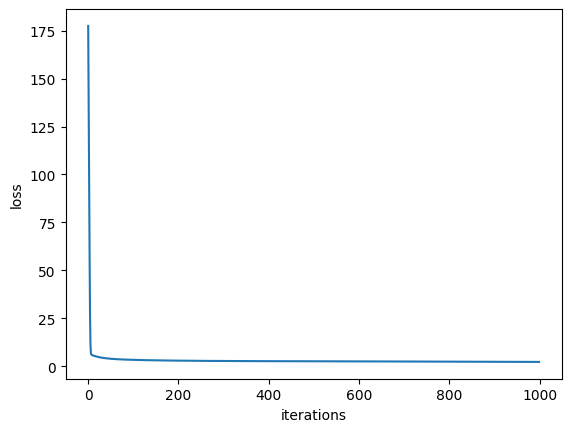

In [21]:
class RewardNet(nn.Module):
    def __init__(self):
        super(RewardNet, self).__init__()
        self.fc1 = nn.Linear(6, 64)  # Input layer: 10 features, Output layer: 64 neurons
        self.fc2 = nn.Linear(64, 1)  # Hidden layer: 64 neurons, Output layer: 1 neurons

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = self.fc2(x)  # Output layer without activation function
        return x

parameter_tensor = torch.from_numpy(df_parameter_norm.to_numpy()).to(torch.float32)
Rset_tensor = torch.from_numpy(df_SE.to_numpy()).to(torch.float32)

# Training data
input_data = parameter_tensor  # 2500 samples, 10 input features
target_data = Rset_tensor.unsqueeze(1)  # 2500 samples, 1 target features

# Create the model
model = RewardNet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
ll = []
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    # Forward pass
    outputs = model(input_data)

    # Compute the loss
    loss = criterion(outputs, target_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ll.append(loss.item())

plt.plot(ll)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14305.59it/s]


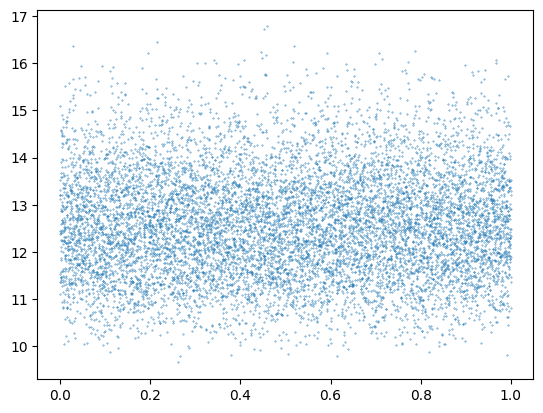

In [22]:
# Testing the model
collect = []
num = 10000

for i in tqdm(range(num)):
    test_input = torch.rand(6)
    with torch.no_grad():
        predicted_output = model(test_input)
    collect.append(predicted_output)

plt.scatter(torch.linspace(0, 1, num), collect, s = 0.1)

In [21]:
max(collect)

tensor([17.1541])

In [22]:
df_SE.max()

19.3119

In [23]:
index_sorted = sorted(range(len(df_SE)), key=lambda k: df_SE[k])
index_sorted[-1]

22

In [24]:
df_SE[index_sorted[-1]]

19.3119

In [25]:
df_parameter_norm.iloc[index_sorted[-1]]

Pulse Duration (nanoSeconds)                                  0.082000
Pulse Frequency (KHz)                                         0.690330
Power (% of 20W Max Output)                                   0.718200
Speed (mm/s)                                                  0.112640
Distance between Passes of Laser (microns)                    0.235187
Ink Type (0=No Ink, 1=TopInk, 2=BottomInk,3=Both Sides Ink    0.000000
Name: 22, dtype: float64

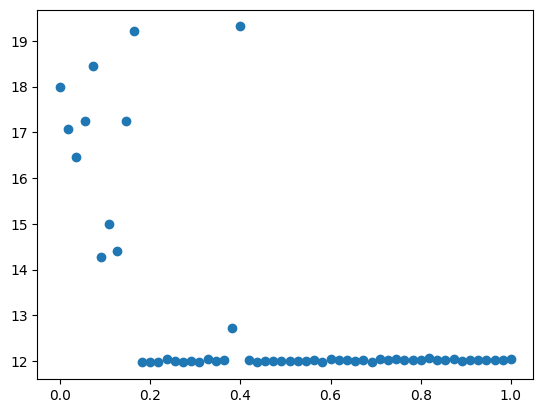

In [28]:
plt.scatter(np.linspace(0, 1, len(df_SE)), df_SE)